## Data download

In [ ]:
# !wget http://images.cocodataset.org/zips/train2014.zip
# !wget http://images.cocodataset.org/zips/val2014.zip
# !wget http://images.cocodataset.org/zips/test2014.zip # not used

In [ ]:
# Download splits and captions in this link:'https://www.kaggle.com/shtvkumar/karpathy-splits'

## Quick implementation

In [ ]:
# !python create_input_files.py
# !python train.py
# !python eval.py
# !python caption.py --img='path/to/img.jpg' \
# --model='path/to/model.pth.tar' \
# --word_map='path/to/WORDMAP.json' --beam_size=5

## Create input files (along with word map) 

In [ ]:
from utils import create_input_files
create_input_files(dataset='coco',
                       karpathy_json_path='../../dataset/COCO/dataset_coco.json',
                       image_folder='../../dataset/COCO/',
                       captions_per_image=5,
                       min_word_freq=5,
                       output_folder='../../dataset/COCO/output/',
                       max_len=50)

In [19]:
from glob import glob
img_list = glob('../../dataset/COCO/test2014/*.jpg')
len(img_list)

40775

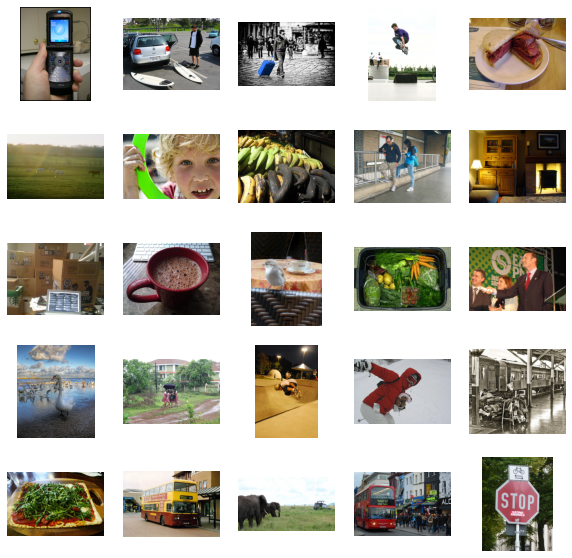

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

w = 10
h = 10
fig = plt.figure(figsize=(10, 10))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = Image.open(img_list[i])
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img)
plt.show()

In [7]:
import json
karpathy_json_path='../../dataset/COCO/dataset_coco.json'

with open(karpathy_json_path, 'r') as j:
    data = json.load(j)

In [8]:
data.keys()

dict_keys(['images', 'dataset'])

In [9]:
data['images'][0]

{'filepath': 'val2014',
 'sentids': [770337, 771687, 772707, 776154, 781998],
 'filename': 'COCO_val2014_000000391895.jpg',
 'imgid': 0,
 'split': 'test',
 'sentences': [{'tokens': ['a',
    'man',
    'with',
    'a',
    'red',
    'helmet',
    'on',
    'a',
    'small',
    'moped',
    'on',
    'a',
    'dirt',
    'road'],
   'raw': 'A man with a red helmet on a small moped on a dirt road. ',
   'imgid': 0,
   'sentid': 770337},
  {'tokens': ['man',
    'riding',
    'a',
    'motor',
    'bike',
    'on',
    'a',
    'dirt',
    'road',
    'on',
    'the',
    'countryside'],
   'raw': 'Man riding a motor bike on a dirt road on the countryside.',
   'imgid': 0,
   'sentid': 771687},
  {'tokens': ['a',
    'man',
    'riding',
    'on',
    'the',
    'back',
    'of',
    'a',
    'motorcycle'],
   'raw': 'A man riding on the back of a motorcycle.',
   'imgid': 0,
   'sentid': 772707},
  {'tokens': ['a',
    'dirt',
    'path',
    'with',
    'a',
    'young',
    'person',

## Train

In [15]:
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
from models import Encoder, DecoderWithAttention
from datasets import *
from utils import *
from nltk.translate.bleu_score import corpus_bleu
from train import train, validate

In [16]:
# Data parameters
data_folder = '../../dataset/COCO/output/'  # folder with data files saved by create_input_files.py
data_name = 'coco_5_cap_per_img_5_min_word_freq'  # base name shared by data files

# Model parameters
emb_dim = 512  # dimension of word embeddings
attention_dim = 512  # dimension of attention linear layers
decoder_dim = 512  # dimension of decoder RNN
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

# Training parameters
start_epoch = 0
epochs = 120  # number of epochs to train for (if early stopping is not triggered)
epochs_since_improvement = 0  # keeps track of number of epochs since there's been an improvement in validation BLEU
batch_size = 32
workers = 1  # for data-loading; right now, only 1 works with h5py
encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder
grad_clip = 5.  # clip gradients at an absolute value of
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
best_bleu4 = 0.  # BLEU-4 score right now
print_freq = 100  # print training/validation stats every __ batches
fine_tune_encoder = False  # fine-tune encoder?
checkpoint = None  # path to checkpoint, None if none

In [ ]:
"""
Training and validation.
"""

global best_bleu4, epochs_since_improvement, checkpoint, start_epoch, fine_tune_encoder, data_name, word_map

# Read word map
word_map_file = os.path.join(data_folder, 'WORDMAP_' + data_name + '.json')
with open(word_map_file, 'r') as j:
    word_map = json.load(j)

# Initialize / load checkpoint
if checkpoint is None:
    decoder = DecoderWithAttention(attention_dim=attention_dim,
                                   embed_dim=emb_dim,
                                   decoder_dim=decoder_dim,
                                   vocab_size=len(word_map),
                                   dropout=dropout)
    decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                         lr=decoder_lr)
    encoder = Encoder()
    encoder.fine_tune(fine_tune_encoder)
    encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                         lr=encoder_lr) if fine_tune_encoder else None

else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    epochs_since_improvement = checkpoint['epochs_since_improvement']
    best_bleu4 = checkpoint['bleu-4']
    decoder = checkpoint['decoder']
    decoder_optimizer = checkpoint['decoder_optimizer']
    encoder = checkpoint['encoder']
    encoder_optimizer = checkpoint['encoder_optimizer']
    if fine_tune_encoder is True and encoder_optimizer is None:
        encoder.fine_tune(fine_tune_encoder)
        encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr)

# Move to GPU, if available
decoder = decoder.to(device)
encoder = encoder.to(device)

# Loss function
criterion = nn.CrossEntropyLoss().to(device)

# Custom dataloaders
## ImageNet mean and std are used
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
train_loader = torch.utils.data.DataLoader(
    CaptionDataset(data_folder, data_name, 'TRAIN', transform=transforms.Compose([normalize])),
    batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
## 'all_captions' are included
val_loader = torch.utils.data.DataLoader(
    CaptionDataset(data_folder, data_name, 'VAL', transform=transforms.Compose([normalize])),
    batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

# Epochs
for epoch in range(start_epoch, epochs):

    # Decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
    if epochs_since_improvement == 20:
        break
    if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
        adjust_learning_rate(decoder_optimizer, 0.8)
        if fine_tune_encoder:
            adjust_learning_rate(encoder_optimizer, 0.8)

    # One epoch's training
    train(train_loader=train_loader,
          encoder=encoder,
          decoder=decoder,
          criterion=criterion,
          encoder_optimizer=encoder_optimizer,
          decoder_optimizer=decoder_optimizer,
          epoch=epoch)

    # One epoch's validation
    recent_bleu4 = validate(val_loader=val_loader,
                            encoder=encoder,
                            decoder=decoder,
                            criterion=criterion)

    # Check if there was an improvement
    is_best = recent_bleu4 > best_bleu4
    best_bleu4 = max(recent_bleu4, best_bleu4)
    if not is_best:
        epochs_since_improvement += 1
        print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
    else:
        epochs_since_improvement = 0

    # Save checkpoint
    save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
                    decoder_optimizer, recent_bleu4, is_best)

## Evaluate

## validation dataset

In [40]:
from eval import evaluate
beam_size = 1
print("\nBLEU-4 score @ beam size of %d is %.4f." % (beam_size, evaluate(beam_size)))

EVALUATING AT BEAM SIZE 1: 100%|██████████| 25000/25000 [11:21<00:00, 36.70it/s]



BLEU-4 score @ beam size of 1 is 0.2824.


### To caption an image

In [44]:
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
import argparse
# from scipy.misc import imread, imresize
from imageio import imread
from PIL import Image
from caption import caption_image_beam_search, visualize_att

In [46]:
img = '../../dataset/COCO/val2014/COCO_val2014_000000581929.jpg'
model = 'BEST_checkpoint_coco_5_cap_per_img_5_min_word_freq.pth.tar'
word_map = '../../dataset/COCO/output/WORDMAP_coco_5_cap_per_img_5_min_word_freq.json'
beam_size = 5

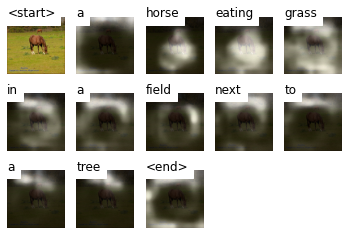

In [47]:
# Load model
checkpoint = torch.load(model, map_location=str(device))
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

# Load word map (word2ix)
with open(word_map, 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

# Encode, decode with attention and beam search
seq, alphas = caption_image_beam_search(encoder, decoder, img, word_map, beam_size)
alphas = torch.FloatTensor(alphas)

# Visualize caption and attention of best sequence
visualize_att(img, seq, alphas, rev_word_map)